## 통계 기반 기법 개선하기
## PMI : 점별 상호 정보량(Pointwise Mutual Information), log 함수
#### 높을수록 관련성이 높다

![image](https://t1.daumcdn.net/cfile/tistory/267AA340587EFB8737)
### PPMI(Positive PMI) : 양의 상호 정보량,  PPMI(x,y) = max(0,PMI(x,y))

In [1]:
from mynlp import preprocess, create_co_matrix, cos_similarity, most_similar
import numpy as np

In [4]:
my_text = 'You say goodbye and I say hello.' 
corpus, word_to_id, id_to_word = preprocess(my_text)
print(corpus)
print(word_to_id)
vocab_size = len(word_to_id)  # 7
C = create_co_matrix(corpus, vocab_size)
print('동시발생행렬:\n',C)
print(C.shape)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
동시발생행렬:
 [[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
(7, 7)


### PPMI 행렬

In [16]:
M = np.zeros_like(C, dtype=np.float32)  # (7,7)

N = np.sum(C)  # 14, 전체 발생 횟수(동시발생행렬 요소 전체의 합)
print(N)

S = np.sum(C, axis=0)  # 동시발생행렬 요소의 수직 방향의 합
print(S)

total = C.shape[0]*C.shape[1]  # 49, 동시발생행렬 요소의 총 갯수

for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        # C[i,j] : 동시발생행렬의 요소한개의 값, 비교하려는 두 단어의 동시발생횟수
        # S[0] : 동시발생행렬에서 열의 'you' 단어의 동시 발생횟수
        # S[i] : 동시발생행렬에서 열의 한 단어의 동시 발생횟수 , 비교하려는 두단어 중 하나 ,x
        # S[j] : 동시발생행렬에서 열 한 단어에 대해 비교하려는 나머지 단어들의 동시 발생횟수, y
        # print(i,j,C[i,j])
        # print('S[%d]:'%i,S[i],'S[%d]:'%j,S[j])
        
        pmi = np.log2(C[i,j]*N / (S[i]*S[j]) + 1e-8)
        M[i,j] = max(0,pmi)

print('PPMI:\n',M)  # PPMI 행렬로 변환
print('C:\n',C)

14
[1 4 2 2 2 2 1]
PPMI:
 [[0.        1.8073549 0.        0.        0.        0.        0.       ]
 [1.8073549 0.        0.8073549 0.        0.8073549 0.8073549 0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.        1.8073549 0.        1.8073549 0.        0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.8073549 0.        0.        0.        0.        2.807355 ]
 [0.        0.        0.        0.        0.        2.807355  0.       ]]
C:
 [[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


In [47]:
# PPMI 행렬 변환 함수 구현
def ppmi(C, verbose=False, eps=1e-8):
    M =  np.zeros_like(C, dtype=np.float32) 
    N = np.sum(C)  
    S = np.sum(C,axis=0)
    total = C.shape[0]*C.shape[1]  
    
    cnt = 0

    for i in range(C.shape[0]) : 
        for j in range(C.shape[1]) :
            pmi = np.log2(C[i,j]*N /(S[i]*S[j]) + eps)
            M[i,j] = max(0,pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0 : # total 이 100 보다 클 때만 사용
                    print('%.1f%% 완료'% (100*cnt/total))            
    return M

In [48]:
my_text = 'You say goodbye and I say hello.' 
corpus, word_to_id, id_to_word = preprocess(my_text)
# print(corpus)
# print(word_to_id)
vocab_size = len(word_to_id)  # 7
C = create_co_matrix(corpus, vocab_size)

W = ppmi(C)
print(W) # 동시발생행렬보다 좀더 나은 확률에 기반한 PPMI행렬로 변환되었다

[[0.   1.81 0.   0.   0.   0.   0.  ]
 [1.81 0.   0.81 0.   0.81 0.81 0.  ]
 [0.   0.81 0.   1.81 0.   0.   0.  ]
 [0.   0.   1.81 0.   1.81 0.   0.  ]
 [0.   0.81 0.   1.81 0.   0.   0.  ]
 [0.   0.81 0.   0.   0.   0.   2.81]
 [0.   0.   0.   0.   0.   2.81 0.  ]]


### SVD(Singular Value Decomposition, 특잇값분해) 에 의한 차원의 축소

#### 차원 축소 알고리즘 정리
- PCA(Principal Component Analysis,주성분 분석) : 데이터의 분산(variance)을 최대한 보존하면서 서로 직교하는 새 기저(축)를 찾아, 고차원 공간의 표본들을 선형 연관성이 없는 저차원 공간으로 변환하는 기법, 정방행렬인 공분산행렬(covariance matrix)을 고유벡터(eigenvector)로 분해한다

 https://ratsgo.github.io/machine%20learning/2017/04/24/PCA/ 
<br>

- SVD(Singular Value Decomposition, 특잇값분해) : 임의의 행렬을 세 행렬의 곱으로 분해

$$ X=USV^T $$
      
   https://angeloyeo.github.io/2019/08/01/SVD.html
  
   https://darkpgmr.tistory.com/106 

[노트북문서화작업]

http://www.onemathematicalcat.org/MathJaxDocumentation/MathJaxKorean/TeXSyntax_ko.html


In [49]:
print(W)

[[0.   1.81 0.   0.   0.   0.   0.  ]
 [1.81 0.   0.81 0.   0.81 0.81 0.  ]
 [0.   0.81 0.   1.81 0.   0.   0.  ]
 [0.   0.   1.81 0.   1.81 0.   0.  ]
 [0.   0.81 0.   1.81 0.   0.   0.  ]
 [0.   0.81 0.   0.   0.   0.   2.81]
 [0.   0.   0.   0.   0.   2.81 0.  ]]


In [50]:
U,S,V = np.linalg.svd(W)  # PPMI 행렬 W를 밀집 벡터 U로 변환

np.set_printoptions(precision=2)
print(U)

[[-3.41e-01 -1.11e-16 -3.89e-16 -1.21e-01  0.00e+00  9.32e-01  2.23e-16]
 [ 0.00e+00 -5.98e-01  1.80e-01  0.00e+00 -7.81e-01  0.00e+00  0.00e+00]
 [-4.36e-01 -4.24e-17 -2.17e-16 -5.09e-01 -1.77e-17 -2.25e-01 -7.07e-01]
 [-2.61e-16 -4.98e-01  6.80e-01 -6.57e-17  5.38e-01  9.95e-17  1.20e-17]
 [-4.36e-01 -3.23e-17 -1.65e-16 -5.09e-01 -1.35e-17 -2.25e-01  7.07e-01]
 [-7.09e-01 -3.23e-17 -1.65e-16  6.84e-01 -1.35e-17 -1.71e-01  5.89e-17]
 [ 3.06e-16 -6.28e-01 -7.10e-01  8.85e-17  3.17e-01 -2.85e-16 -1.55e-17]]


In [51]:
# 차원을 줄이려면 처음 2개의 요소를 꺼내면 된다
print(U[:,:2])  # (7, 7) --> (7, 2)로 축소됨

[[-3.41e-01 -1.11e-16]
 [ 0.00e+00 -5.98e-01]
 [-4.36e-01 -4.24e-17]
 [-2.61e-16 -4.98e-01]
 [-4.36e-01 -3.23e-17]
 [-7.09e-01 -3.23e-17]
 [ 3.06e-16 -6.28e-01]]


you 0
say 1
goodbye 2
and 3
i 4
hello 5
. 6


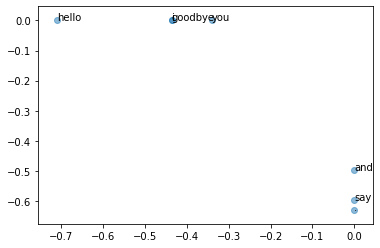

In [52]:
# 시각화
import matplotlib.pyplot as plt
for word, word_id in word_to_id.items(): # 7회
    print(word,word_id)
    plt.annotate(word,(U[word_id,0],U[word_id,1]))

plt.scatter(U[:,0],U[:,1], alpha=0.5)
plt.show()

# ('goodbye', 2) : [-4.36e-01 -4.24e-17]
#     ('i', 4)   : [-4.36e-01 -3.23e-17] , 두 개의 좌표값이 거의 동일하여 그래프에 i가 안보임

# 'goodbye'와 'hello', 'you'와 'i' 가 비교적 가까이 있음, 말뭉치 데이터셋이 아주 적어서 신뢰할 수 없음

In [53]:
word_to_id.items()

dict_items([('you', 0), ('say', 1), ('goodbye', 2), ('and', 3), ('i', 4), ('hello', 5), ('.', 6)])

### PTB 데이터셋  : Penn Treebank 말뭉치 , word2vec의 발명자 토마스미콜로프의 웹에 게시
 https://raw.githubusercontent.com/tomsercu/lstm/master/data/ptb.train.txt

In [54]:
from dataset import ptb

window_size = 2
wordvec_size = 100  # 축소할 차원 수

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print(vocab_size)  # 10000
print(len(corpus)) # 929589

print("동시발생 수 계산...")
C = create_co_matrix(corpus,vocab_size,window_size)
print(C.shape)  # (10000, 10000)
print(C)

10000
929589
동시발생 수 계산...
(10000, 10000)
[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [55]:
print('PPMI 계산...')
W = ppmi(C,verbose=True)
# 약 8~10분 소요

PPMI 계산...


C:\Users\Wonseok\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in long_scalars
  if sys.path[0] == '':
C:\Users\Wonseok\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log2
  if sys.path[0] == '':


1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
100.0% 완료


In [56]:
print(W.shape)  # (10000, 10000)
W

(10000, 10000)


array([[ 0.  , 19.24, 18.83, ...,  0.  ,  0.  ,  0.  ],
       [19.24,  0.  , 18.24, ...,  0.  ,  0.  ,  0.  ],
       [18.83, 18.24,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]], dtype=float32)

In [59]:
# SVD 사용 차원 축소
print('Calculating SVD...')

# numpy : 속도가 느리다
# U,S,V = np.linalg.svd(W)

# Truncated SVD : 속도가 빠르다
from sklearn.utils.extmath import randomized_svd

U,S,V = randomized_svd(W,n_components=wordvec_size,n_iter=5,random_state=None)  # 100개로 차원 축소

print(U.shape)  # (10000, 100)

word_vecs = U[:,:wordvec_size]
print(word_vecs.shape)  # (10000, 100)
word_vecs

Calculating SVD...
(10000, 100)
(10000, 100)


array([[-1.39e-10,  8.15e-07,  2.74e-07, ..., -2.52e-05, -2.17e-05,
         5.60e-05],
       [-7.80e-12, -7.36e-09, -5.14e-09, ..., -3.87e-05, -2.61e-05,
         8.41e-05],
       [-1.23e-11,  1.11e-08, -6.00e-08, ..., -7.35e-05, -3.83e-05,
         1.09e-04],
       ...,
       [ 4.43e-03, -6.48e-03,  1.15e-02, ..., -1.51e-03,  1.74e-03,
         2.36e-03],
       [ 2.46e-03, -4.92e-03,  8.03e-03, ...,  1.43e-03, -2.93e-03,
        -3.88e-03],
       [ 3.89e-03, -7.84e-03,  8.08e-03, ...,  7.55e-03, -8.91e-03,
         1.05e-03]], dtype=float32)

In [60]:
most_similar('say',word_to_id,id_to_word,word_vecs,top=5)


[query] say
 believe: 0.6123064160346985
 contend: 0.5578373670578003
 argue: 0.5389249920845032
 expect: 0.5313212871551514
 predict: 0.5162341594696045


In [66]:
most_similar('i',word_to_id,id_to_word,word_vecs,top=5)


[query] i
 we: 0.6952572464942932
 you: 0.6890751123428345
 'm: 0.6679012179374695
 've: 0.589279055595398
 am: 0.5574151277542114


In [64]:
most_similar('you',word_to_id,id_to_word,word_vecs,top=5)


[query] you
 i: 0.6890751123428345
 we: 0.6517750024795532
 anybody: 0.5681681632995605
 'll: 0.5270262956619263
 do: 0.5212717056274414


In [65]:
most_similar('and',word_to_id,id_to_word,word_vecs,top=5)


[query] and
 <unk>: 0.6056305170059204
 for: 0.4883480966091156
 of: 0.46939677000045776
 <eos>: 0.4557322859764099
 in: 0.45417022705078125


In [61]:
most_similar('N',word_to_id,id_to_word,word_vecs,top=5)


[query] N
 $: 0.6974402666091919
 cents: 0.6704565286636353
 million: 0.649509608745575
 average: 0.6329135894775391
 pence: 0.6022524833679199


In [62]:
querys = ['you','year','car','toyota']
for query in querys:
    most_similar(query,word_to_id,id_to_word,word_vecs,top=5)


[query] you
 i: 0.6890751123428345
 we: 0.6517750024795532
 anybody: 0.5681681632995605
 'll: 0.5270262956619263
 do: 0.5212717056274414

[query] year
 month: 0.6725155115127563
 february: 0.5919483304023743
 next: 0.5882875919342041
 earlier: 0.5833106637001038
 june: 0.5825566053390503

[query] car
 luxury: 0.6820144653320312
 auto: 0.6044037938117981
 corsica: 0.5867443084716797
 cars: 0.5632621645927429
 gm: 0.49659132957458496

[query] toyota
 motor: 0.7214187383651733
 nissan: 0.6557305455207825
 motors: 0.6472770571708679
 honda: 0.6228241920471191
 lexus: 0.622809648513794
